In [262]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import csv
import nltk


In [263]:
# loading the data

def load_data(filename):
    with open(filename) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        textlines = []
        sentiments = []
        for row in readCSV:
            textline = row[0]
            sentiment = row[1]

            textlines.append(textline)
            sentiments.append(sentiment)

    textlines.remove(textlines[0])
    sentiments.remove(sentiments[0])
    
    return textlines, sentiments

# loading data from news_summary_2.csv
textlines, sentiments = load_data('sentiment_data.csv')


In [264]:
# dictionary for expanding contractions

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [265]:
def text_cleaner(text):
    newString = text.lower()
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    newString = re.sub(r'[^a-zA-Z0-9_\s]+', '', newString)
    return newString

# cleaning the articles
cleaned_text = []
for t in textlines:
    cleaned_text.append(text_cleaner(t))



In [266]:
data=pd.DataFrame()
data['text']=cleaned_text
data['sentiments']=sentiments

In [267]:
cnt=0
for i in data['text']:
    if(len(i.split())<=35):
        cnt=cnt+1
print(cnt/len(data['text']))

0.9994278739797086


In [268]:
max_text_len=35

In [269]:
text =np.array(data['text'])
sentiments=np.array(data['sentiments'])

short_text=[]
senti=[]

for i in range(len(text)):
    if(len(cleaned_text[i].split())<=max_text_len):
        short_text.append(text[i])
        senti.append(sentiments[i])
        
df=pd.DataFrame({'text':short_text,'sentiments':senti})
export_csv = df.to_csv ('classifier_data.csv', index = None, header=True)

In [89]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(df,test_size=0.1,random_state=0,shuffle=True)

x_tr = train_data['text']
x_val = test_data['text']
y_tr = train_data['sentiments']
y_val = test_data['sentiments']

In [90]:
# saving the x_tr for training
#export_csv = train_data.to_csv ('train_data.csv', index = None, header=True)

In [91]:
# Building tokenizer to convert word sequence into integer sequence

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

# Analysing the number of rare words in the vocabulary (rule: any word that appears 3 or leass times is rare)

thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for articles on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

% of rare words in vocabulary: 36.82070493638212
Total Coverage of rare words: 1.4418483997352274


In [92]:
import tensorflow as tf
class Attention(Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
 
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [93]:
sequence_input = Input(shape=(max_text_len,))

In [94]:
embed_seq = Embedding(x_voc, 100, input_length=max_text_len)(sequence_input)

In [95]:
import os
rnn_cell_size = 128
lstm = Bidirectional(LSTM(rnn_cell_size,dropout=0.3,return_sequences=True,return_state=True,
                          recurrent_activation='relu',recurrent_initializer='glorot_uniform'))(embed_seq)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
    (LSTM(rnn_cell_size,dropout=0.2,return_sequences=True,return_state=True,
      recurrent_activation='relu',recurrent_initializer='glorot_uniform'))(lstm)

In [99]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

attention = Attention(100)

context_vector, attention_weights = attention(lstm, state_h)
 
output = Dense(1, activation='sigmoid')(context_vector)
 
model = Model(inputs=sequence_input, outputs=[output,attention_weights])
#model = Model(inputs=sequence_input, outputs = output)
 
# summarize layers
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 100)      2765900     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 35, 256), (N 234496      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 35, 256), (N 394240      bidirectional_2[0][0]            
                                                                 bidirectional_2[0][1]            
          

In [97]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
 
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto')

In [98]:
#history = model.fit(x_tr,[y_tr,out[1]],epochs=10,batch_size=200,validation_split=.3, verbose=1, callbacks=[es])

history = model.fit(x_tr,y_tr,epochs=10,batch_size=200,validation_split=.3, verbose=1, callbacks=[es])

Train on 33015 samples, validate on 14150 samples
Epoch 1/10
33015/33015 [==============================] - 138s 4ms/sample - loss: 0.6390 - acc: 0.6721 - val_loss: 0.6216 - val_acc: 0.6711
Epoch 2/10
33015/33015 [==============================] - 138s 4ms/sample - loss: 0.5739 - acc: 0.6981 - val_loss: 0.6160 - val_acc: 0.6771
Epoch 3/10
33015/33015 [==============================] - 134s 4ms/sample - loss: 0.4895 - acc: 0.7611 - val_loss: 0.6664 - val_acc: 0.6624


In [144]:
out = model.predict(x_tr)

In [145]:
out[1].shape


(47165, 35, 1)

In [146]:
x_tr.shape

(47165, 35)

In [147]:
y_tr = list(y_tr)

In [148]:
for i in range (len(y_tr)):
    y_tr[i] = float(y_tr[i])

In [149]:
print("no. of positives = ",np.sum(y_tr))
print("no. of negatives = ",len(y_tr)-np.sum(y_tr))
print("shape of x_tr = ",x_tr.shape)

no. of positives =  15479.0
no. of negatives =  31686.0
shape of x_tr =  (47165, 35)


In [150]:
trained_att = out[1]
print("shape of attention_weights = ", trained_att.shape)
new_trained_att = np.reshape(trained_att,(trained_att.shape[0],trained_att.shape[1]))
print("shape of attention_weights = ", new_trained_att.shape)

for i in range(new_trained_att.shape[0]):
    avg = np.mean(new_trained_att[i,:])
    for j in range(new_trained_att.shape[1]):
        if(new_trained_att[i,j]>=avg):
            new_trained_att[i,j]=1
        else:
            new_trained_att[i,j]=0

shape of attention_weights =  (47165, 35, 1)
shape of attention_weights =  (47165, 35)


In [151]:
x_pos = np.empty((15479,35))
x_neg = np.empty((31686,35))

att_pos = np.empty((15479,35))
att_neg = np.empty((31686,35))

p,n = 0,0

for i in range(len(y_tr)):
    if(y_tr[i]==1):
        x_pos[p,:] = x_tr[i,:]
        att_pos[p,:] = new_trained_att[i,:]
        p = p+1
    elif(y_tr[i]==0):
        x_neg[n,:] = x_tr[i,:]
        att_neg[n,:] = new_trained_att[i,:]
        n = n+1


In [152]:
np.save('x_pos',x_pos)
np.save('x_neg',x_neg)
np.save('attn_pos',att_pos)
np.save('attn_neg',att_neg)

In [153]:
np.save('attention_weights.npy',out[1])

In [156]:
s_pos = np.sum(x_pos*att_pos,axis=0)
context_attention = 1-att_pos
s_cont = np.sum(x_pos*context_attention,axis=0)

alpha = 100
e = 35

In [157]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class Positive_Memory(Model):
    def __init__(self, e, alpha):
        super(Positive_Memory, self).__init__()
        self.M_pos = np.ones((e,alpha))
 
    def call(self, s_pos, s_cont):
        w = softmax((s_pos.T)@self.M_pos)
        self.M_pos = self.M_pos + np.outer(s_pos,w)
        u = softmax((s_cont.T)@self.M_pos)
        m_bar = np.sum(u*self.M_pos)
        
        return m_bar

In [158]:
hidden_dim = 20
embedding_dim = 100

encoder_inputs = Input(shape=(max_text_len, ), dtype='int32',)
encoder_embedding = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
encoder_LSTM = LSTM(hidden_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

pos_sentiment_memory = Positive_Memory(e,alpha)
m_bar = pos_sentiment_memory(s_pos,s_cont)
state_c1 = state_c + m_bar

decoder_embedding = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
decoder_LSTM = LSTM(hidden_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

dense_layer = Dense(x_voc, activation='softmax')
#outputs = TimeDistributed(Dense(x_voc, activation='softmax'))(decoder_outputs)
outputs = dense_layer(decoder_outputs)
final_model = Model(encoder_inputs, outputs)

final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 100)      2765900     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 100)      2765900     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 20), (None,  9680        embedding_2[0][0]                
__________________________________________________________________________________________________
lstm_5 (LS

In [159]:
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [222]:
final_history = final_model.fit((x_pos*context_attention),x_pos, epochs=50 , batch_size=128) 

Epoch 1/50
15479/15479 [==============================] - 586s 38ms/sample - loss: 5.2647
Epoch 2/50
15479/15479 [==============================] - 566s 37ms/sample - loss: 5.1666
Epoch 3/50
15479/15479 [==============================] - 571s 37ms/sample - loss: 5.1085
Epoch 4/50
15479/15479 [==============================] - 563s 36ms/sample - loss: 5.0696
Epoch 5/50
15479/15479 [==============================] - 550s 36ms/sample - loss: 5.0418
Epoch 6/50
15479/15479 [==============================] - 571s 37ms/sample - loss: 5.0227
Epoch 7/50
15479/15479 [==============================] - 574s 37ms/sample - loss: 5.0052
Epoch 8/50
15479/15479 [==============================] - 574s 37ms/sample - loss: 4.9913
Epoch 9/50
15479/15479 [==============================] - 573s 37ms/sample - loss: 4.9794
Epoch 10/50
15479/15479 [==============================] - 575s 37ms/sample - loss: 4.9674
Epoch 11/50
15479/15479 [==============================] - 574s 37ms/sample - loss: 4.9558
Epoch 12

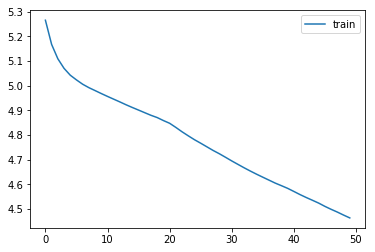

In [257]:
from matplotlib import pyplot
pyplot.plot(final_history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [260]:
sentence = []
for j in (x_pos[10]):
    if(j!=0):
        sentence.append(x_tokenizer.index_word[j])
        
print(' '.join(sentence))

political and military leaders have concluded that it would be better for israel not to overthrow the hamas government in the gaza strip officials who took part in


In [240]:
a = x_pos[10]
print(a.shape)

(35,)


In [248]:
ans = final_model.predict(x_pos[9:10])

In [249]:
ans.shape

(1, 35, 27659)

In [250]:
print(a.shape)

(35, 27659)


In [251]:
print(ans)
print(ans.shape)
a = ans[0,:,:]

[[[3.9737389e-04 8.4439462e-01 5.5298511e-02 ... 1.3321880e-10
   9.7233197e-08 1.4851062e-10]
  [4.1279194e-04 4.3840893e-03 5.2244011e-03 ... 1.6885822e-07
   7.5822859e-06 1.8363259e-07]
  [3.3615634e-02 1.4062191e-04 1.3812333e-03 ... 1.2417185e-08
   1.3803078e-06 1.3351100e-08]
  ...
  [9.9821341e-01 3.0102306e-05 1.0714332e-04 ... 2.1064203e-12
   1.0191362e-09 2.3513565e-12]
  [9.9821556e-01 3.0124571e-05 1.0720467e-04 ... 2.0982044e-12
   1.0161958e-09 2.3422570e-12]
  [9.9821717e-01 3.0139130e-05 1.0724473e-04 ... 2.0929998e-12
   1.0143267e-09 2.3364869e-12]]]
(1, 35, 27659)


In [252]:
print(a.shape)

b = np.empty((35))

#print(a[0,:])

for i in range(35):
    b[i] = np.argmax(a[i,:])

(35, 27659)


In [253]:
b

array([  1.,   3.,   0.,   5.,   1.,   9.,   4.,   2.,   1.,   3.,   3.,
         0.,   1.,   5., 179.,   0.,   6.,   3.,   6.,   4.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.])

In [261]:
predicted = []
for j in (b):
    if(j!=0):
        predicted.append(x_tokenizer.index_word[j])

print(' '.join(predicted))

the of in the has to a the of of the in them and of and to
